In [121]:
%load_ext autoreload
from ddls.plotting.plotting import plot_line, plot_bar, plot_hist, PlotAesthetics

from collections import defaultdict
from sqlitedict import SqliteDict
import pprint
import glob
import os
import time
import pandas as pd
import numpy as np
import scipy.stats as st
import sigfig

import gzip
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [122]:
# set paths to agent(s)

base_folder = '/scratch/datasets/ddls/sims/'

# base_name = 'job_placing'
# # ids = [108]
# ids = [108, 116]

# base_name = 'ramp_job_placement_shaping'
base_name = 'ramp_job_partitioning'
agent_to_id = {
    
    # 'Random': 349,
    # 'First Fit': 350,
    # 'Last Fit': 351,
    # # 'RL': f'{base_folder}/{base_name}/{base_name}_{348}/checkpoints/checkpoint_000002/',
    # 'RL': 363,
    
    # AlexNet
    # 'First Fit': 381,
    # 'RL': f'{base_folder}/{base_name}/{base_name}_{385}/checkpoints/checkpoint_000006/',
    
    # # 5 'small' graphs (image classification and NMT) -> 1000 in an episode (replication_factor=200)
    # 'First Fit': 441,
    # # 'RL': f'{base_folder}/{base_name}/{base_name}_{437}/checkpoints/checkpoint_000002/',
    
    
    
    
    # RAMP_JOB_PARTITIONING
    
    # # 200 AlexNet, max_partitions_per_op=None
    # 'Random': 64,
    # 'No\nPara': 78,
    # 'Max\nPara': 79,
    # 'SiP-ML': 67,
    # 'RL\n(JCT)': f'{base_folder}/{base_name}/{base_name}_{104}/checkpoints/checkpoint_000023/',
    # 'RL\n(Acc)': f'{base_folder}/{base_name}/{base_name}_{103}/checkpoints/checkpoint_000500/',
    
    # 20 small_graphs, max_partitions_per_op=8
    'Random': 191,
    'No\nPara': 192,
    'Max\nPara': 193,
    'SiP-ML': 194,
    # 'RL\n(JCT)': f'{base_folder}/{base_name}/{base_name}_{104}/checkpoints/checkpoint_000023/',
    # 'RL\n(Acc)': f'{base_folder}/{base_name}/{base_name}_{103}/checkpoints/checkpoint_000500/',
    
}

In [126]:
# load data

episode_metrics = {
    'num_jobs_arrived',
    'num_jobs_completed',
    'num_jobs_blocked',
    # 'return',
}

episode_completion_metrics = {
    'job_completion_time',
    'job_communication_overhead_time',
    'job_computation_overhead_time',
    'jobs_completed_num_nodes',
    'jobs_completed_num_edges',
    'jobs_completed_total_operation_memory_cost',
    'jobs_completed_total_dependency_size',
}

episode_blocked_metrics = {
    'jobs_blocked_num_nodes',
    'jobs_blocked_num_edges',
    'jobs_blocked_total_operation_memory_cost',
    'jobs_blocked_total_dependency_size',
}

# 'jobs_blocked_causes', # TODO: Process strings properly below when plotting
step_metrics = set()

agent_to_episode_stats_dict = defaultdict(list)
agent_to_episode_completion_stats_dict = defaultdict(list)
agent_to_episode_blocked_stats_dict = defaultdict(list)

agent_to_step_stats_dict = defaultdict(list)

for agent, _id in agent_to_id.items():
    if isinstance(_id, int):
        # use int id to generate string dir to data
        agent_dir = base_folder + f'{base_name}/{base_name}_{_id}/'
    else:
        # string dir to data already provided
        agent_dir = _id
    if os.path.isdir(agent_dir):
        print(f'\nLoading validation data from {agent_dir[:-1]}...')
            
        completion_stats_found, blocked_stats_found = False, False

        # load episode stats
        with gzip.open(agent_dir+'episode_stats.pkl', 'rb') as f:
            episode_stats = pickle.load(f)
        for metric, result in episode_stats.items():
            if metric in episode_metrics:
                try:
                    agent_to_episode_stats_dict[metric].extend(result)
                except TypeError:
                    agent_to_episode_stats_dict[metric].append(result)
            elif metric in episode_completion_metrics:
                completion_stats_found = True
                try:
                    agent_to_episode_completion_stats_dict[metric].extend(result)
                except TypeError:
                    agent_to_episode_completion_stats_dict[metric].append(result)
            elif metric in episode_blocked_metrics:
                blocked_stats_found = True
                try:
                    agent_to_episode_blocked_stats_dict[metric].extend(result)
                except TypeError:
                    agent_to_episode_blocked_stats_dict[metric].append(result)
            else:
                raise Exception(f'Unrecognised metric {metric}')
        agent_to_episode_stats_dict['Agent'].append(agent)
        if completion_stats_found:
            agent_to_episode_completion_stats_dict['Agent'].append(agent)
        if blocked_stats_found:
            agent_to_episode_blocked_stats_dict['Agent'].append(agent)

        # load step stats
        with gzip.open(agent_dir+'step_stats.pkl', 'rb') as f:
            step_stats = pickle.load(f)
        for metric, result in step_stats.items():
            try:
                agent_to_step_stats_dict[metric].extend(result)
            except TypeError:
                agent_to_step_stats_dict[metric].append(result)
            step_metrics.add(metric)
        agent_to_step_stats_dict['Agent'].extend([agent for _ in range(len(result))])
        
        print(f'Checkpoints loaded from {agent_dir[:-1]}.')
    else:
        print(f'\nNo checkpoints/ folder found in {agent_dir[:-1]}')
       
print(f'\nEpisode stats:')
# print(agent_to_episode_stats_dict)
episode_stats_df = pd.DataFrame(agent_to_episode_stats_dict)
display(episode_stats_df)
# print(agent_to_episode_completion_stats_dict)
episode_completion_stats_df = pd.DataFrame(agent_to_episode_completion_stats_dict)
display(episode_completion_stats_df)
# print(agent_to_episode_blocked_stats_dict)
episode_blocked_stats_df = pd.DataFrame(agent_to_episode_blocked_stats_dict)
display(episode_blocked_stats_df)

print(f'\nStep stats:')
# print(agent_to_step_stats_dict)
# for key, val in agent_to_step_stats_dict.items():
#     print(f'{key} -> {len(val)} vals')
step_stats_df = pd.DataFrame(agent_to_step_stats_dict)
display(step_stats_df)


Loading validation data from /scratch/datasets/ddls/sims/ramp_job_partitioning/ramp_job_partitioning_191...
Checkpoints loaded from /scratch/datasets/ddls/sims/ramp_job_partitioning/ramp_job_partitioning_191.

Loading validation data from /scratch/datasets/ddls/sims/ramp_job_partitioning/ramp_job_partitioning_192...
Checkpoints loaded from /scratch/datasets/ddls/sims/ramp_job_partitioning/ramp_job_partitioning_192.

Loading validation data from /scratch/datasets/ddls/sims/ramp_job_partitioning/ramp_job_partitioning_193...
Checkpoints loaded from /scratch/datasets/ddls/sims/ramp_job_partitioning/ramp_job_partitioning_193.

Loading validation data from /scratch/datasets/ddls/sims/ramp_job_partitioning/ramp_job_partitioning_194...
Checkpoints loaded from /scratch/datasets/ddls/sims/ramp_job_partitioning/ramp_job_partitioning_194.

Episode stats:


,num_jobs_arrived,num_jobs_completed,num_jobs_blocked,Agent
0,100.0,58.0,42.0,Random
1,100.0,97.0,3.0,No\nPara
2,100.0,48.0,52.0,Max\nPara
3,100.0,48.0,52.0,SiP-ML


,job_completion_time,job_communication_overhead_time,job_computation_overhead_time,jobs_completed_num_nodes,jobs_completed_num_edges,jobs_completed_total_operation_memory_cost,jobs_completed_total_dependency_size,Agent
0,20696.494056,20696.494056,20653.603697,226.068966,1313.051724,1.639166e+10,2.916951e+10,Random
1,29787.671649,29787.671649,29787.671649,101.340206,113.061856,1.547349e+10,1.656609e+10,No\nPara
2,8040.224058,8040.224058,7844.042744,614.666667,6254.479167,1.433234e+10,6.025447e+10,Max\nPara
3,8040.224058,8040.224058,7844.042744,614.666667,6254.479167,1.433234e+10,6.025447e+10,SiP-ML


,jobs_blocked_num_nodes,jobs_blocked_num_edges,jobs_blocked_total_operation_memory_cost,jobs_blocked_total_dependency_size,Agent
0,98.142857,108.857143,1.463116e+10,1.504346e+10,Random
1,70.000000,71.000000,2.143228e+10,2.045209e+10,No\nPara
2,103.307692,115.000000,1.687063e+10,1.706390e+10,Max\nPara
3,103.307692,115.000000,1.687063e+10,1.706390e+10,SiP-ML



Step stats:


,action,reward,step_counter,step_start_time,mean_num_mounted_workers,mean_num_mounted_channels,mean_compute_throughput,mean_comm_throughput,mean_cluster_throughput,mean_compute_overhead_frac,mean_comm_overhead_frac,mean_mounted_worker_utilisation_frac,mean_cluster_worker_utilisation_frac,num_jobs_completed,mean_num_jobs_running,num_jobs_arrived,num_jobs_blocked,step_end_time,job_queue_length,Agent
0,4,-1.000000,0,0.0,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000,NaN,NaN,0,0.0,1,1,1000.00000,1,Random
1,2,-0.062585,1,1000.0,2.000000,2.000000,1.049633e+06,1.773791e+06,2.823424e+06,1.0,1.000000,0.798919,0.049932,0,1.0,1,0,2000.00000,1,Random
2,8,-0.032740,2,2000.0,10.000000,58.000000,2.487212e+06,7.836236e+06,1.032345e+07,1.0,0.994838,0.590355,0.184486,0,2.0,1,0,3000.00000,1,Random
3,1,-0.100000,3,3000.0,11.000000,58.000000,3.144120e+06,8.570972e+06,1.171509e+07,1.0,0.996559,0.726903,0.249873,0,3.0,1,0,4000.00000,1,Random
4,1,-0.100000,4,4000.0,12.000000,58.000000,3.673879e+06,9.312832e+06,1.298671e+07,1.0,0.997419,0.795177,0.298192,0,4.0,1,0,5000.00000,1,Random
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,8,-1.000000,137,95000.0,17.500000,112.000000,4.109024e+06,1.663141e+07,2.074043e+07,1.0,0.992751,0.632185,0.346547,1,3.5,1,1,96000.00000,1,SiP-ML
396,8,-0.100000,138,96000.0,18.000000,112.000000,4.373904e+06,1.764948e+07,2.202338e+07,1.0,0.993787,0.684730,0.385161,0,4.0,1,0,97000.00000,1,SiP-ML
397,8,-1.000000,141,97000.0,12.333333,74.666667,2.946113e+06,1.196093e+07,1.490704e+07,1.0,0.995061,0.723185,0.275859,2,3.0,1,1,98000.00000,1,SiP-ML
398,8,-0.100000,142,98000.0,10.000000,56.000000,2.497097e+06,1.013473e+07,1.263183e+07,1.0,0.996559,0.793930,0.248103,0,3.0,1,0,99000.00000,1,SiP-ML


In [127]:
aesthetics = PlotAesthetics()
aesthetics.set_icml_paper_plot_aesthetics() # paper training curve

estimator = np.mean # np.mean np.median

scaling_factor = 1
width_scaling_factor = 1
height_scaling_factor = 1

step_stats_xaxis = 'step_end_time'
step_stats_xaxis_label = 'Time (s)'

legend = 'auto'

ylog = False
xlog = False

ci = None
errcolor = 'gray'
capsize = 0.05


# display bar chart values
display_values = True
# display_values = False
y_offset = 0
# loc = 'bottom'
loc = 'top'




def show_values_on_bars(axs, sigfigs=2, y_offset=0, loc='top'):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            if loc == 'top':
                _x = p.get_x() + p.get_width() / 2
    #             _y = p.get_y() + p.get_height()
    #             _y = p.get_y() + y_offset
                _y = p.get_height() + y_offset
                value = sigfig.round(p.get_height(), sigfigs=sigfigs)
                ax.text(_x, _y, value, ha="center") 
            elif loc == 'bottom':
                _x = p.get_x() + p.get_width() / 2
    #             _y = p.get_y() + p.get_height()
                _y = p.get_y() + y_offset
                value = sigfig.round(p.get_height(), sigfigs=sigfigs)
                ax.text(_x, _y, value, ha="center") 
            else:
                raise Exception(f'Unrecognised loc {loc}')

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

def barplot(df, metric, x='Agent', display_values=True):
    print(f'Plotting metric {metric} -> min={np.min(df[metric])} | max={np.max(df[metric])} | mean={np.mean(df[metric])}')
    f, ax = plt.subplots(figsize=aesthetics.get_standard_fig_size(scaling_factor=scaling_factor, width_scaling_factor=width_scaling_factor, height_scaling_factor=height_scaling_factor))
    g = sns.barplot(data=df,
                    x=x,
                    y=metric,
                    # order=order,
                    # palette=palette,
                    estimator=estimator,
                    ci=ci,
                    errcolor=errcolor,
                    capsize=capsize)
    g.set_xlabel('Agent')
    g.set_ylabel(metric)
    ax.tick_params(axis='both', which='major', pad=2)
    plt.xticks(fontsize=7.5)
    ax.xaxis.labelpad = 2
    # ax.xaxis.label.set_size(2)
    ax.yaxis.labelpad = 2
    sns.despine(ax=ax) # remove top and right spines
    if ylog:
        g.set(yscale='log')
    if xlog:
        g.set(xscale='log')
    if display_values:
        show_values_on_bars(ax, sigfigs=3, y_offset=y_offset, loc=loc)
    plt.gcf().patch.set_alpha(0.0)
    plt.show()
    
def lineplot(df, metric):
    print(f'Plotting metric {metric} -> min={np.min(df[metric])} | max={np.max(df[metric])} | mean={np.mean(df[metric])}')
    f, ax = plt.subplots(figsize=aesthetics.get_standard_fig_size(scaling_factor=scaling_factor, width_scaling_factor=width_scaling_factor, height_scaling_factor=height_scaling_factor))
    g = sns.lineplot(data=df, 
                     x=step_stats_xaxis, 
                     y=metric, 
                     hue='Agent', 
                     linewidth=aesthetics.linewidth, 
                     legend=legend)
    # g = sns.scatterplot(data=episode_stats_df, x=xaxis, y=metric, hue='Agent', linewidth=aesthetics.linewidth, legend=legend)
    plt.title(metric)
    ax.tick_params(axis='both', which='major', pad=2)
    ax.xaxis.labelpad = 2
    ax.yaxis.labelpad = 2
    sns.despine(ax=ax) # remove top and right spines
    plt.gcf().patch.set_alpha(0.0)
    plt.show()



EPISODE METRICS
Plotting metric num_jobs_blocked -> min=3.0 | max=52.0 | mean=37.25


/scratch/zciccwf/py36/envs/ddls/lib/python3.9/site-packages/sigfig/sigfig.py:585: UserWarning: warning: 3 significant figures requested from number with only 2 significant figures
  warn("warning: %d significant figures requested from number with only %d significant figures" % (given['sigfigs'], len(num.map)))


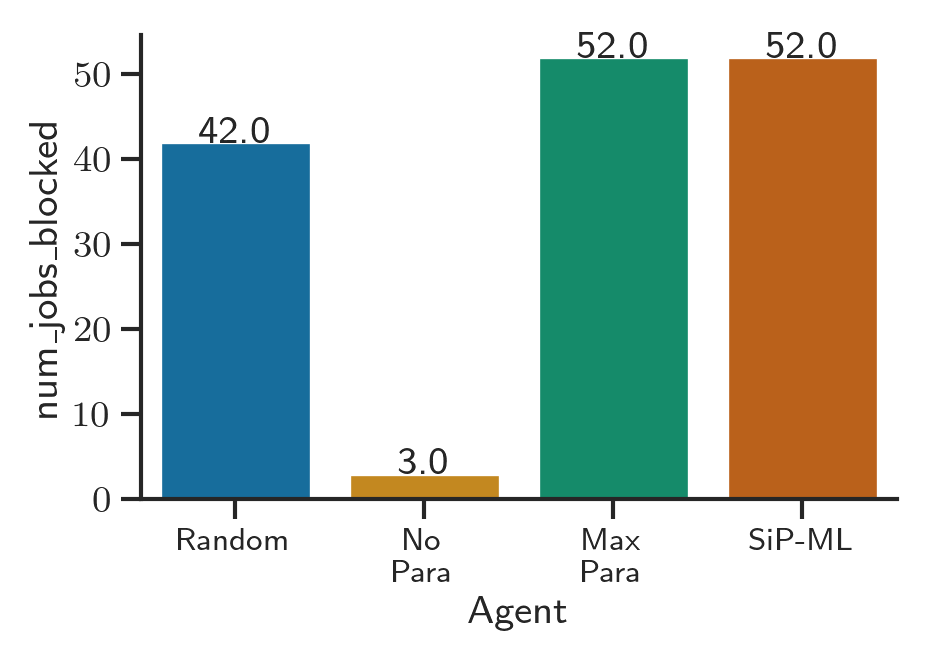

Plotting metric num_jobs_arrived -> min=100.0 | max=100.0 | mean=100.0


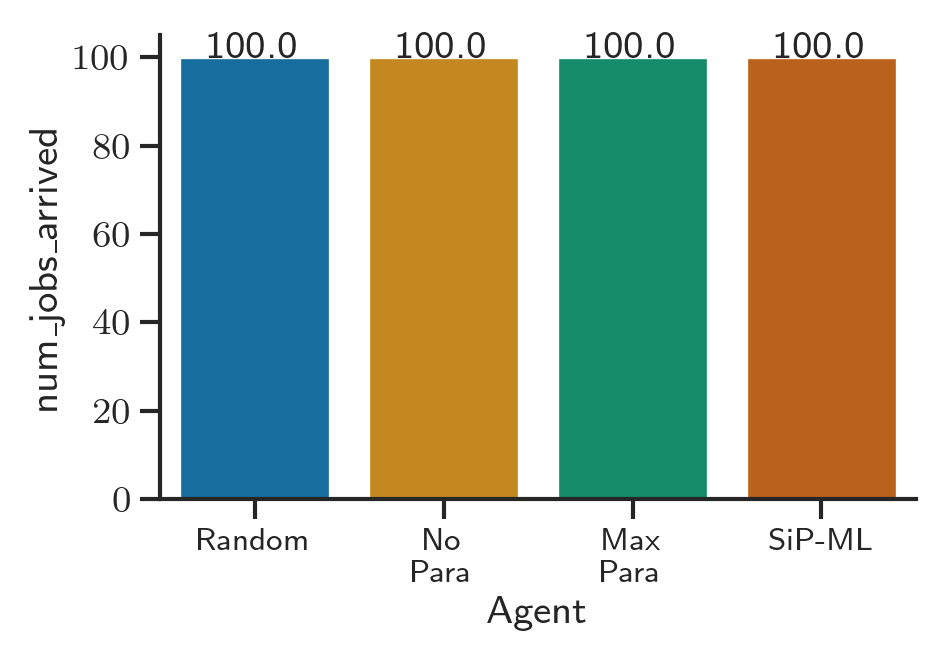

Plotting metric num_jobs_completed -> min=48.0 | max=97.0 | mean=62.75


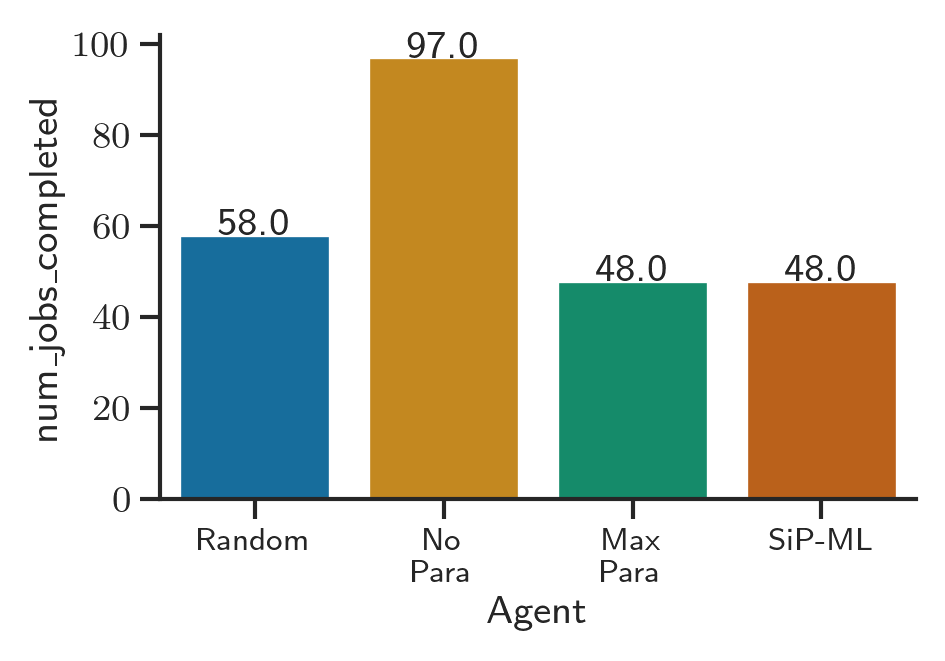

Plotting metric jobs_completed_num_edges -> min=113.0618556701031 | max=6254.479166666667 | mean=3483.767978285342


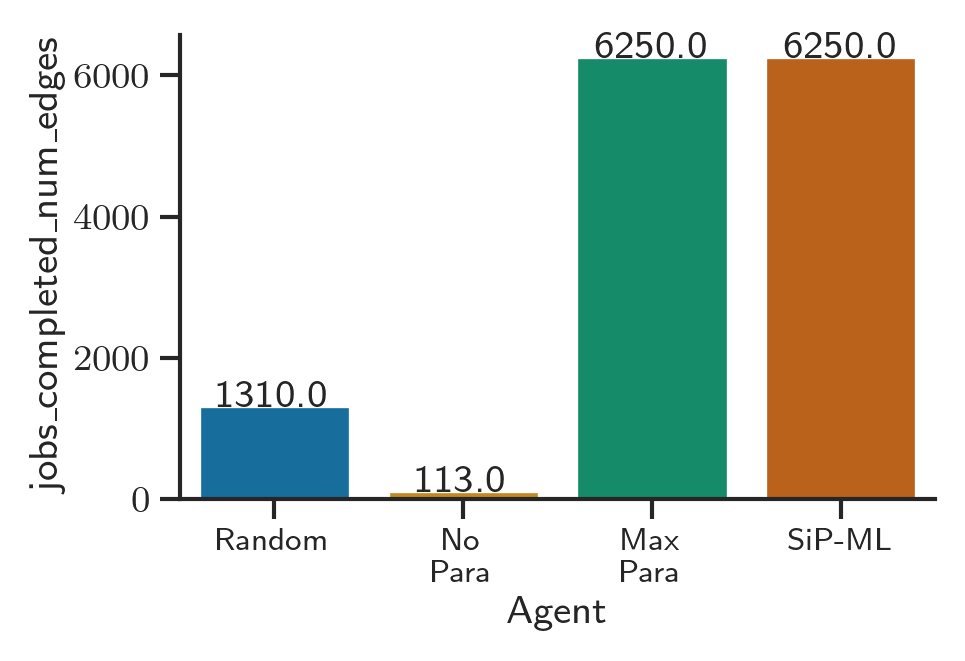

Plotting metric job_completion_time -> min=8040.224057533643 | max=29787.67164948454 | mean=16641.15345513222


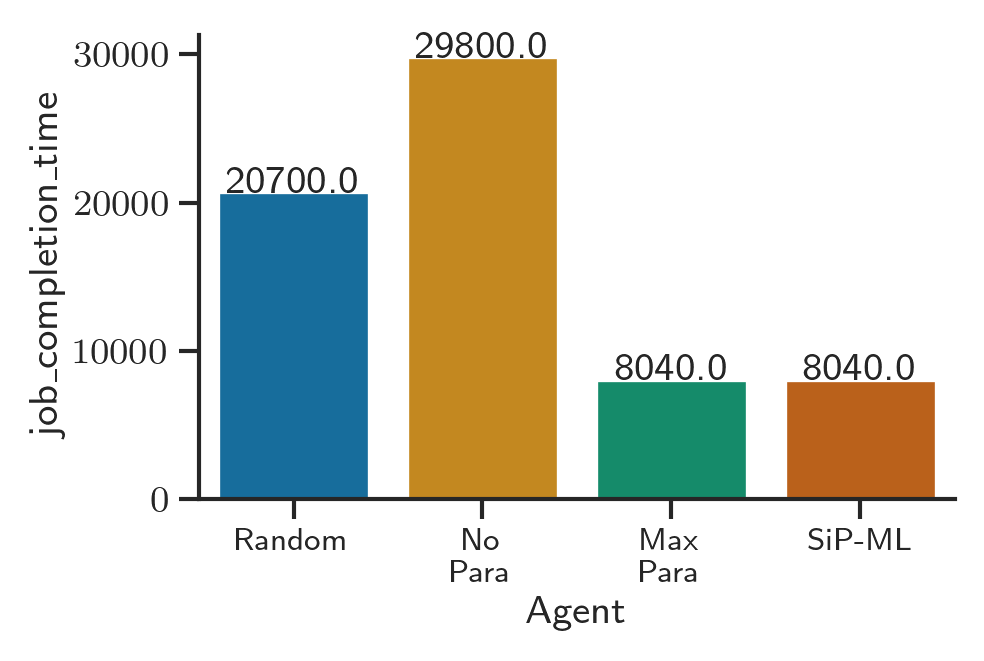

Plotting metric job_computation_overhead_time -> min=7844.042744471245 | max=29787.671649484546 | mean=16532.340208770813


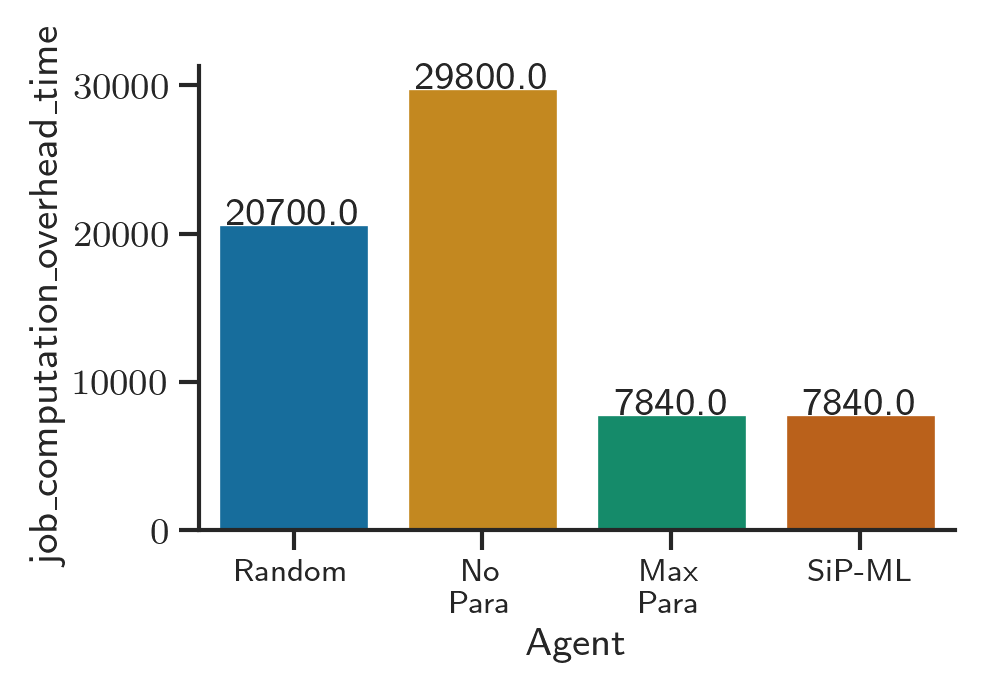

Plotting metric jobs_completed_total_operation_memory_cost -> min=14332338773.166666 | max=16391661781.51724 | mean=15132456865.055426


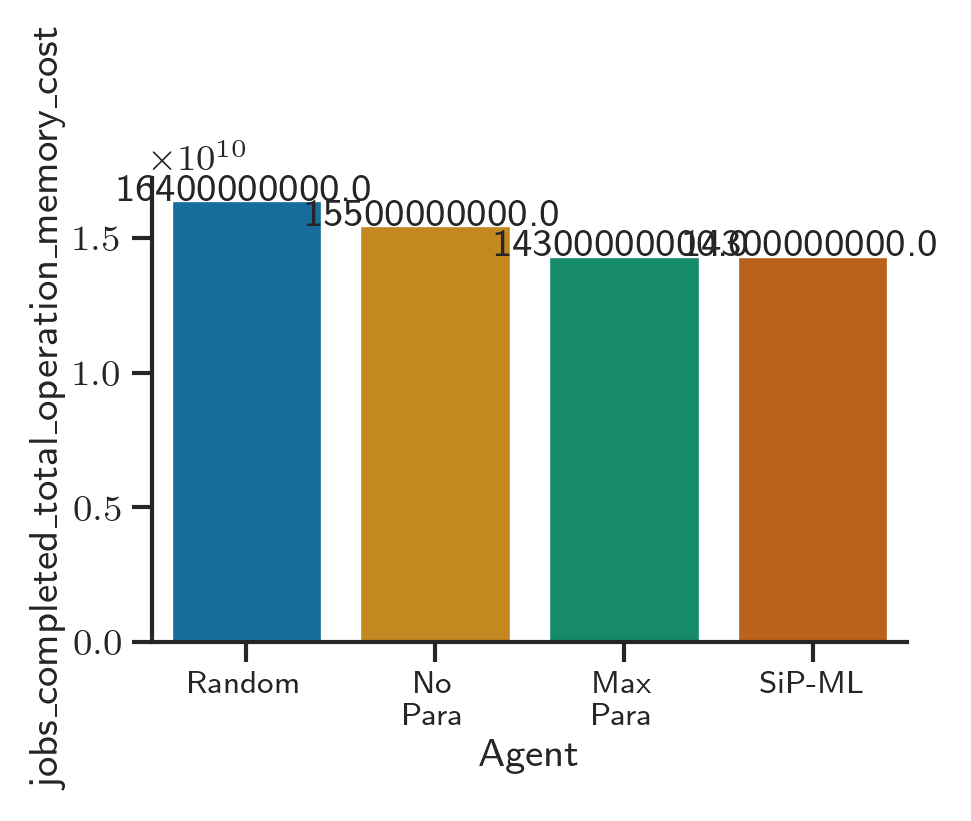

Plotting metric job_communication_overhead_time -> min=8040.224057533641 | max=29787.671649484546 | mean=16641.153455132222


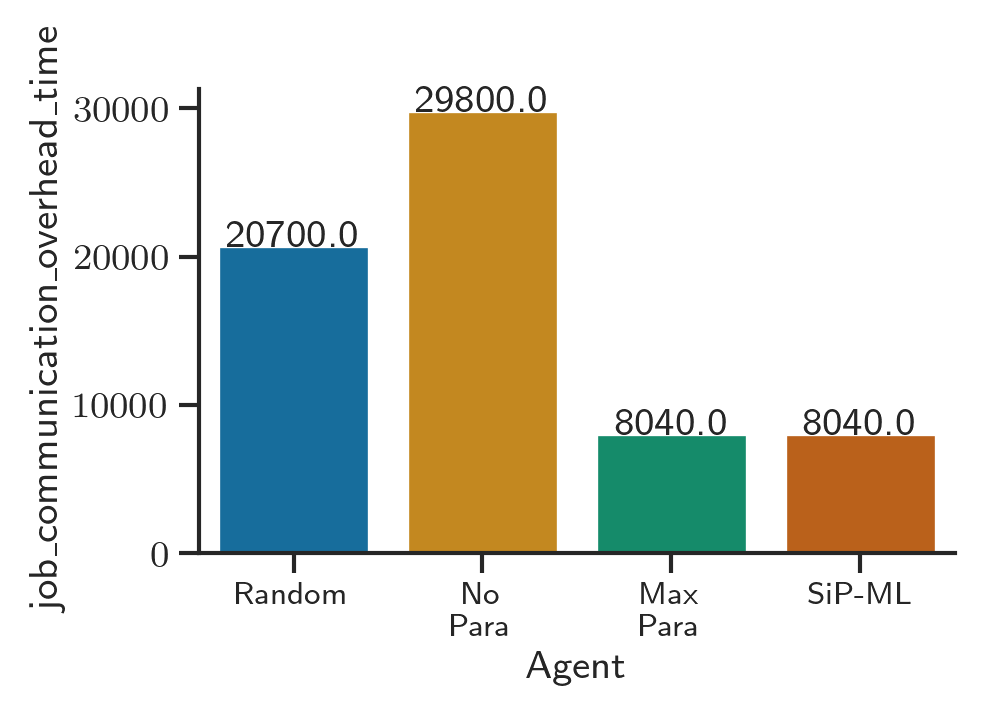

Plotting metric jobs_completed_total_dependency_size -> min=16566090305.072165 | max=60254465737.083336 | mean=41561133171.1373


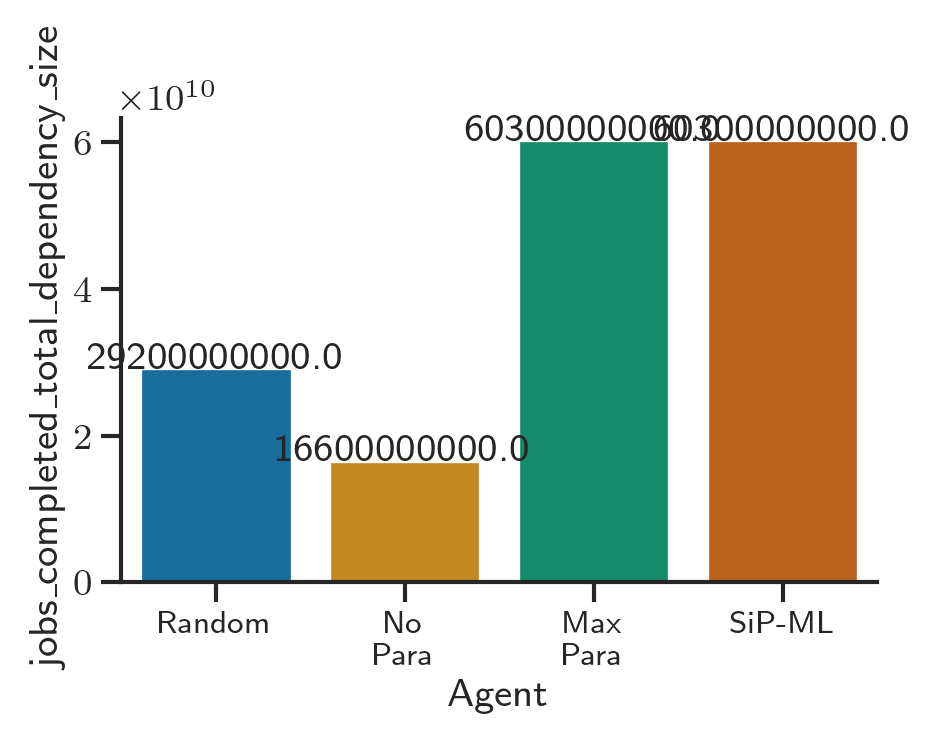

Plotting metric jobs_completed_num_nodes -> min=101.34020618556701 | max=614.6666666666666 | mean=389.1856262590354


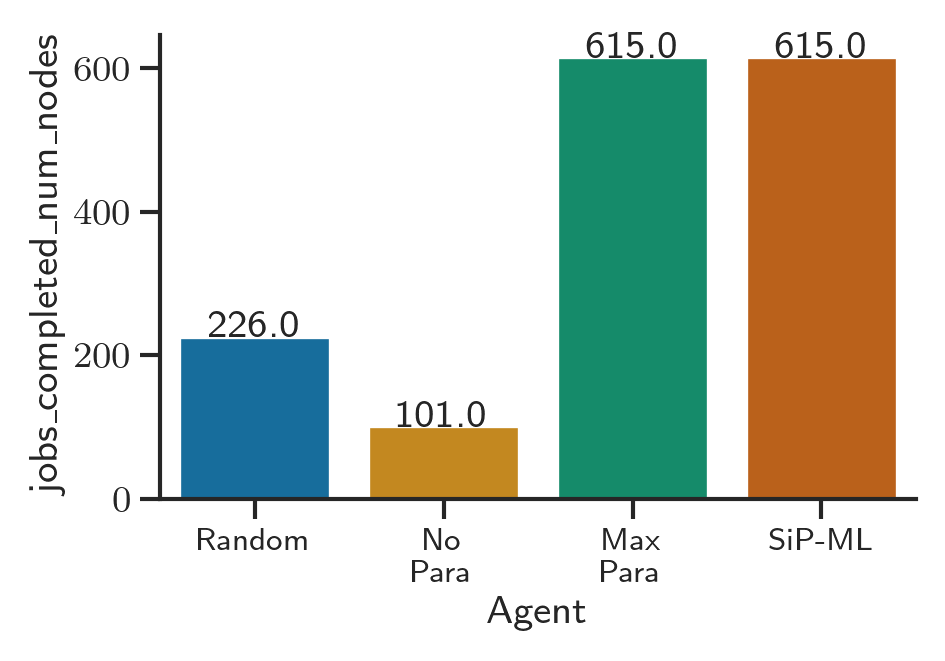

Plotting metric jobs_blocked_num_nodes -> min=70.0 | max=103.3076923076923 | mean=93.68956043956044


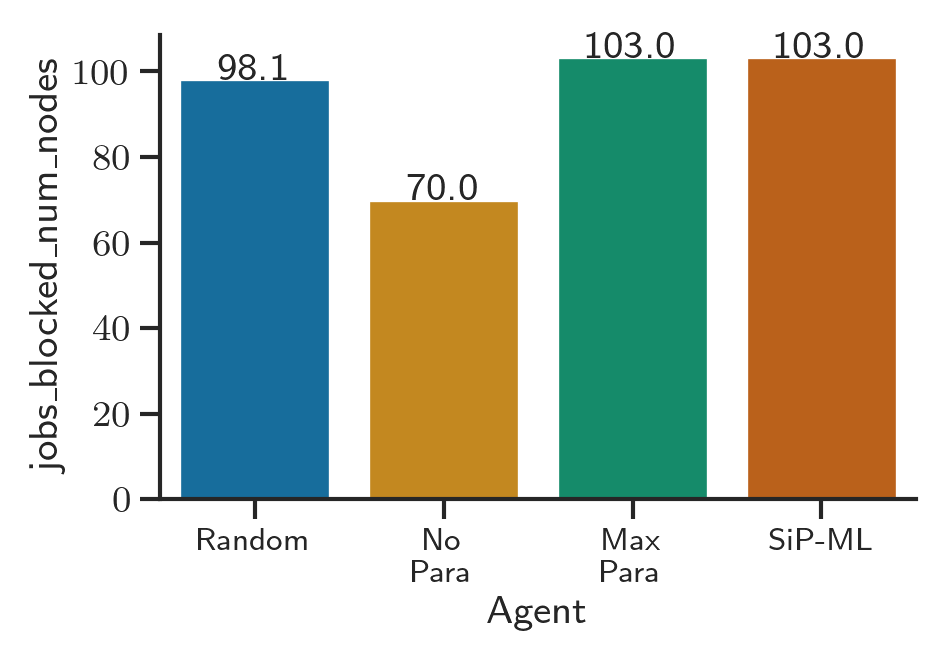

Plotting metric jobs_blocked_num_edges -> min=71.0 | max=115.0 | mean=102.46428571428572


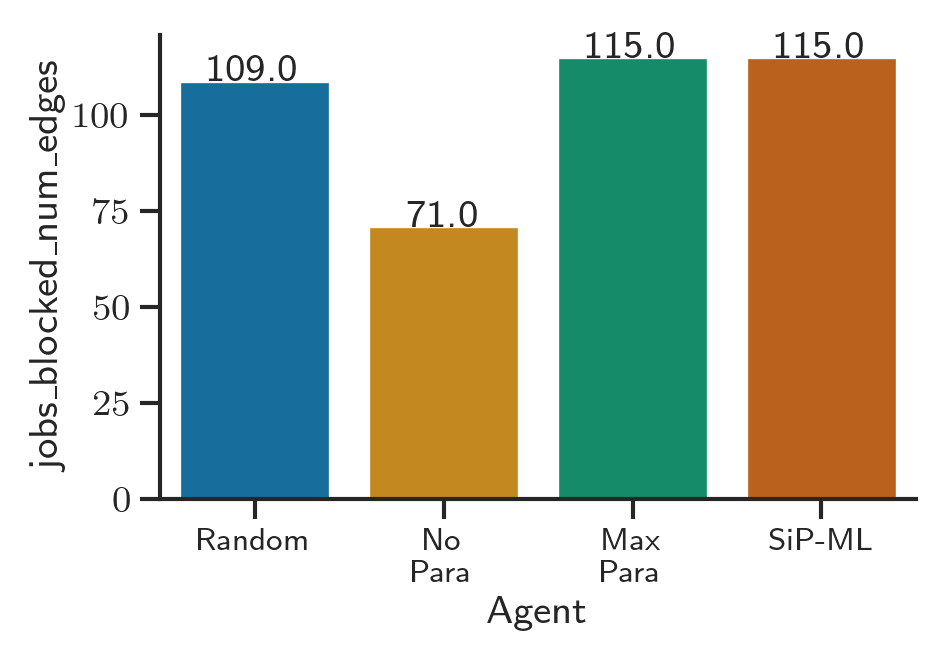

Plotting metric jobs_blocked_total_dependency_size -> min=15043464637.714285 | max=20452092594.666668 | mean=17405841006.018314


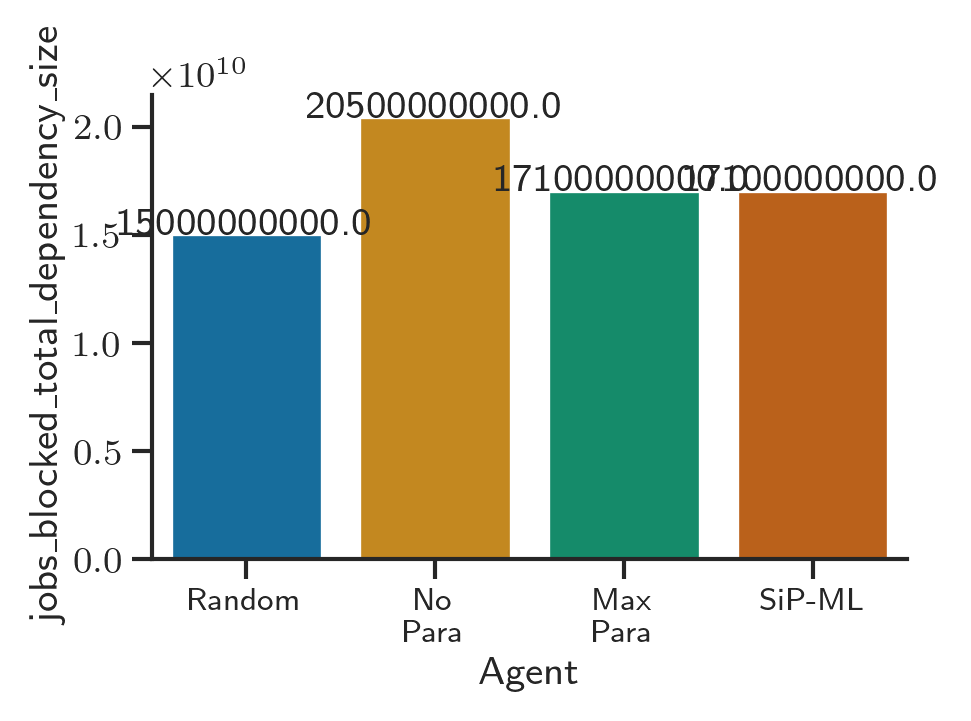

Plotting metric jobs_blocked_total_operation_memory_cost -> min=14631161844.571428 | max=21432277320.0 | mean=17451176326.604397


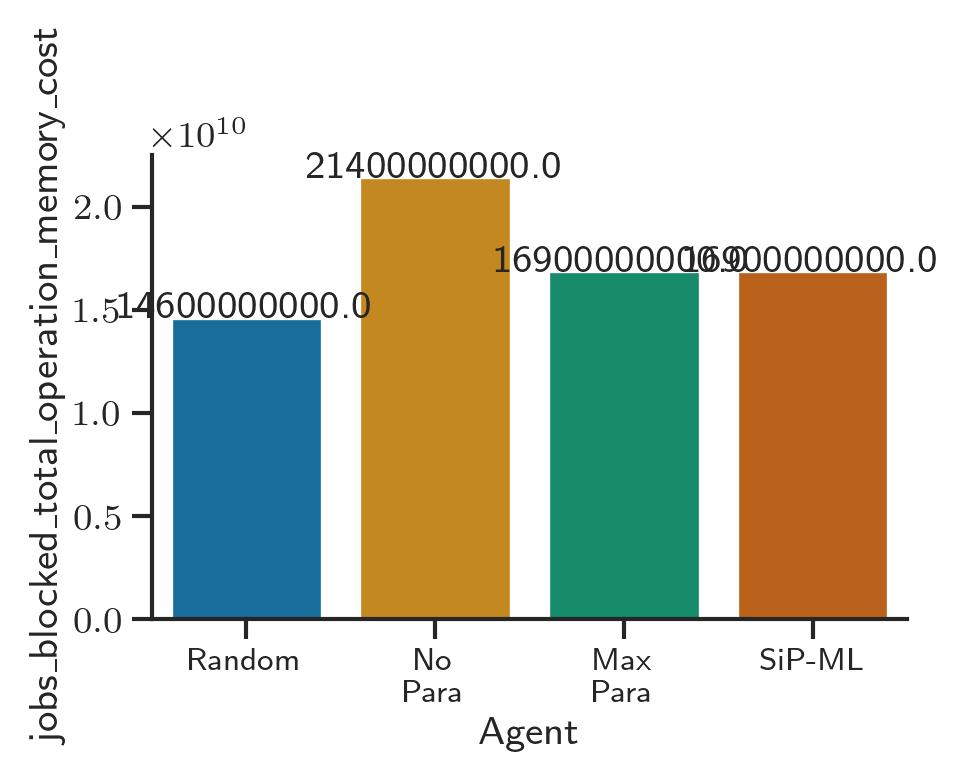



STEP METRICS
Plotting metric mean_cluster_throughput -> min=0.0 | max=58746072.508455664 | mean=29813139.83543423


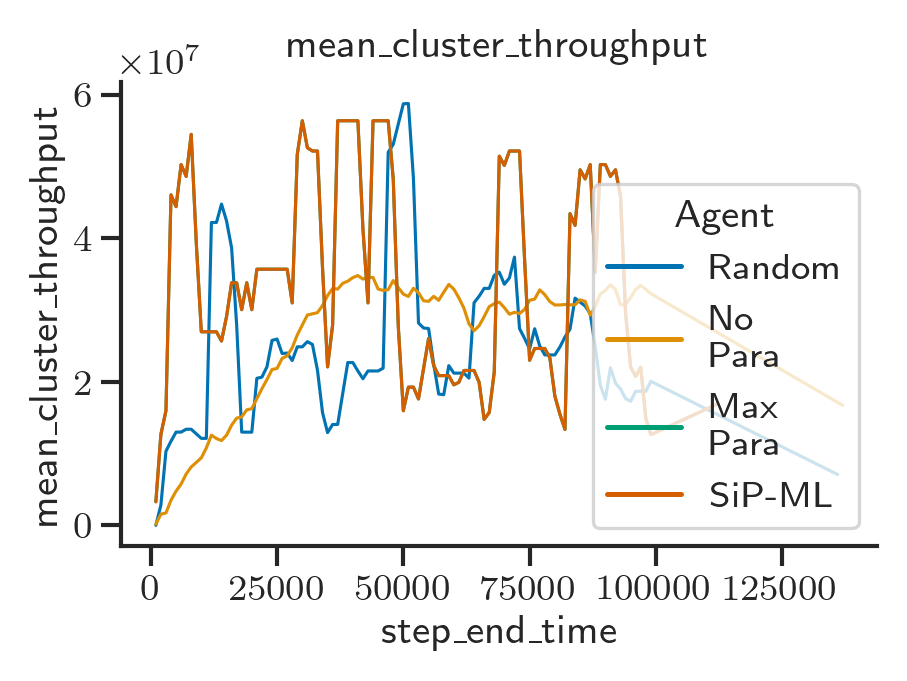

Plotting metric mean_num_mounted_workers -> min=0.0 | max=32.0 | mean=23.936458333333334


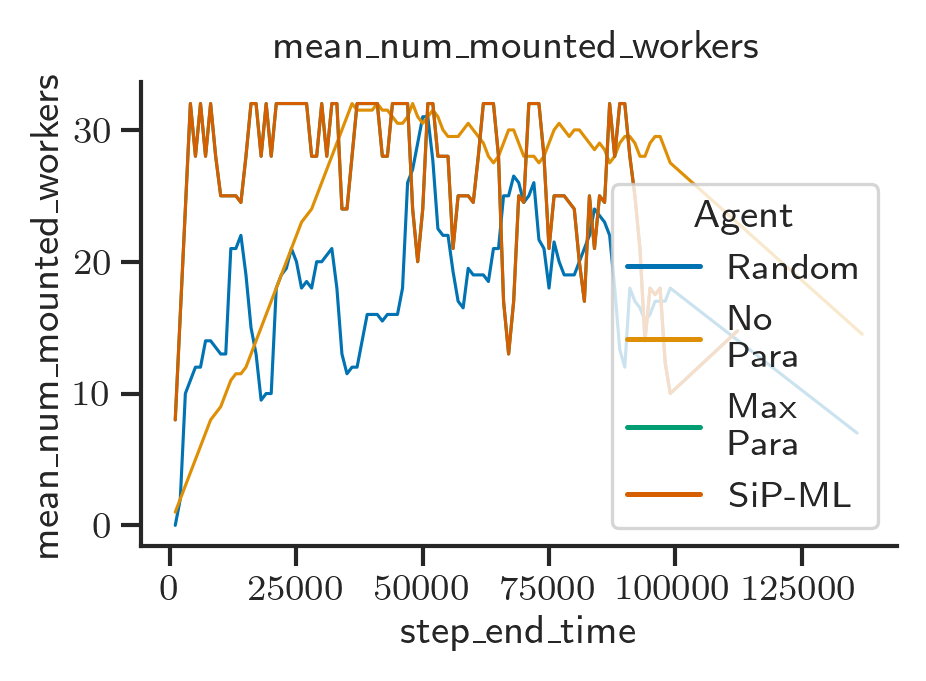

Plotting metric mean_comm_overhead_frac -> min=0.0 | max=1.0 | mean=0.9845032003511404


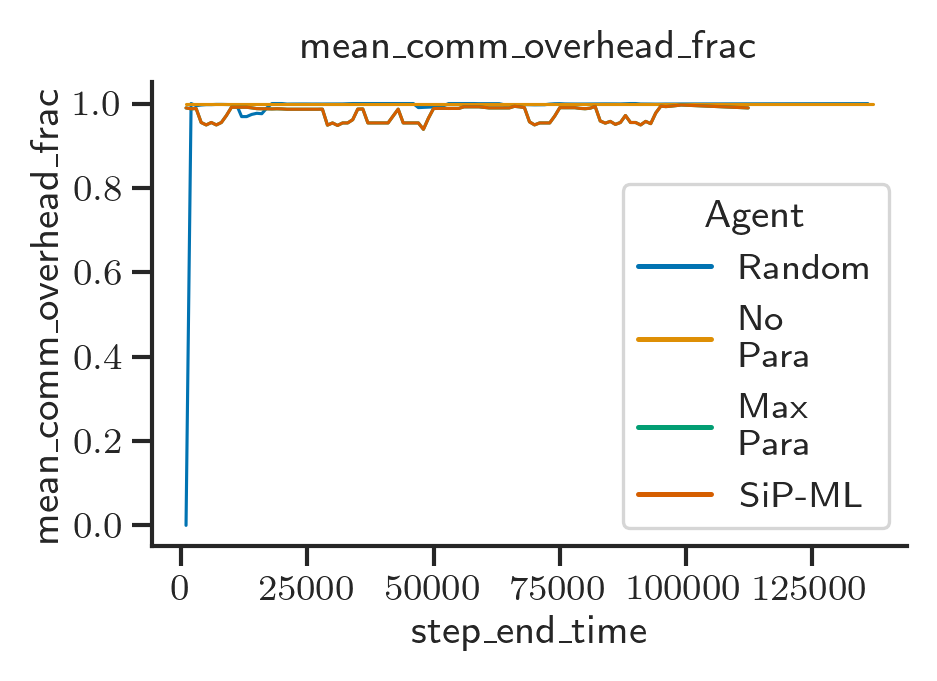

Plotting metric num_jobs_arrived -> min=0 | max=1 | mean=0.99


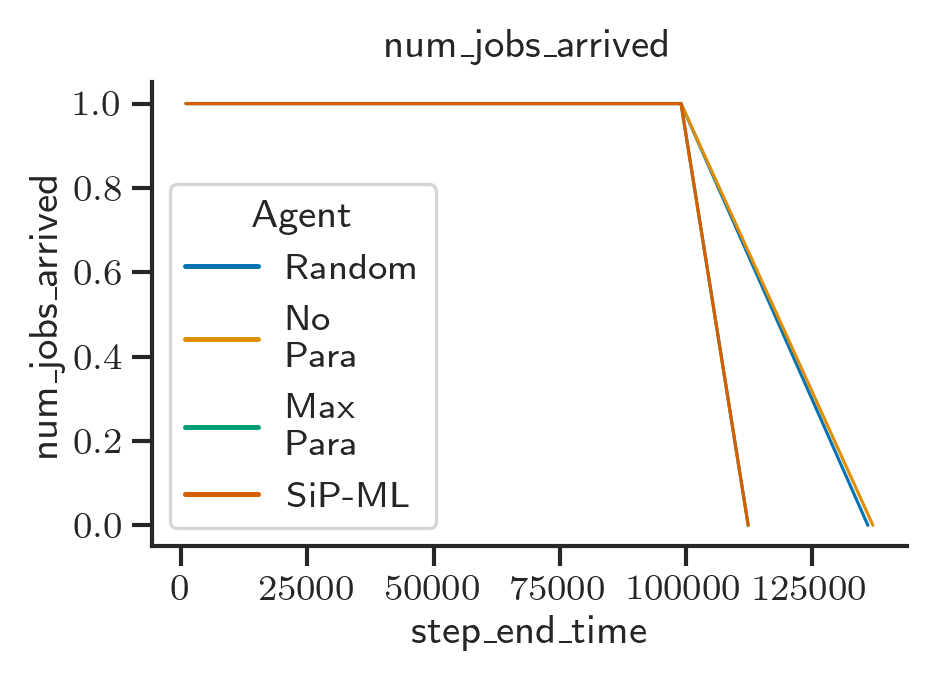

Plotting metric mean_mounted_worker_utilisation_frac -> min=0.36329432372079135 | max=1.0 | mean=0.7635549613652305


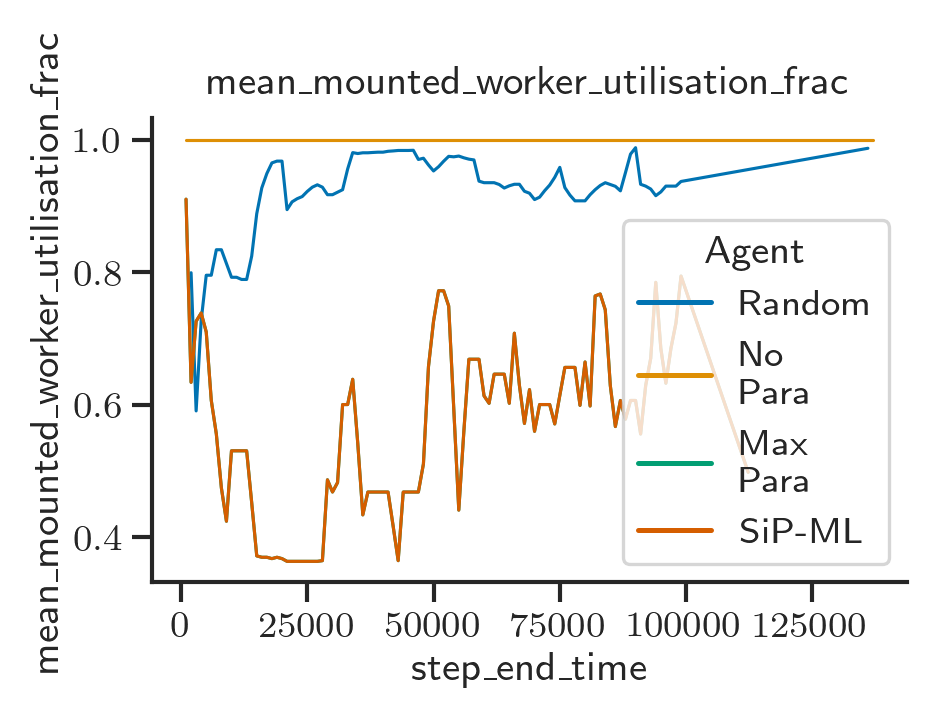

Plotting metric mean_compute_throughput -> min=0.0 | max=18006983.974181365 | mean=8611495.54938364


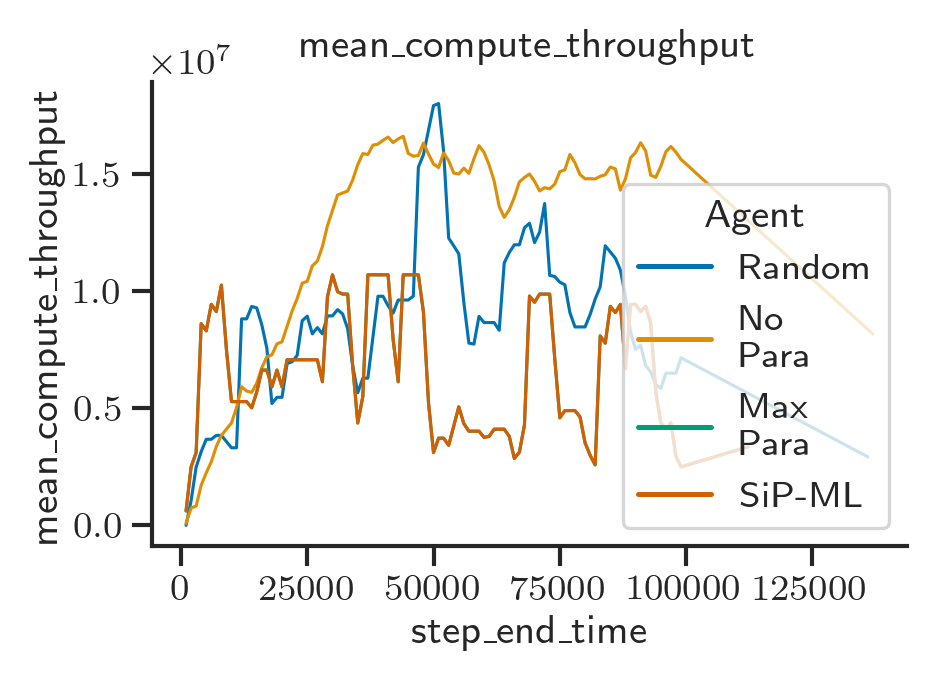

Plotting metric step_end_time -> min=1000.0 | max=137000.15 | mean=50744.00365719933


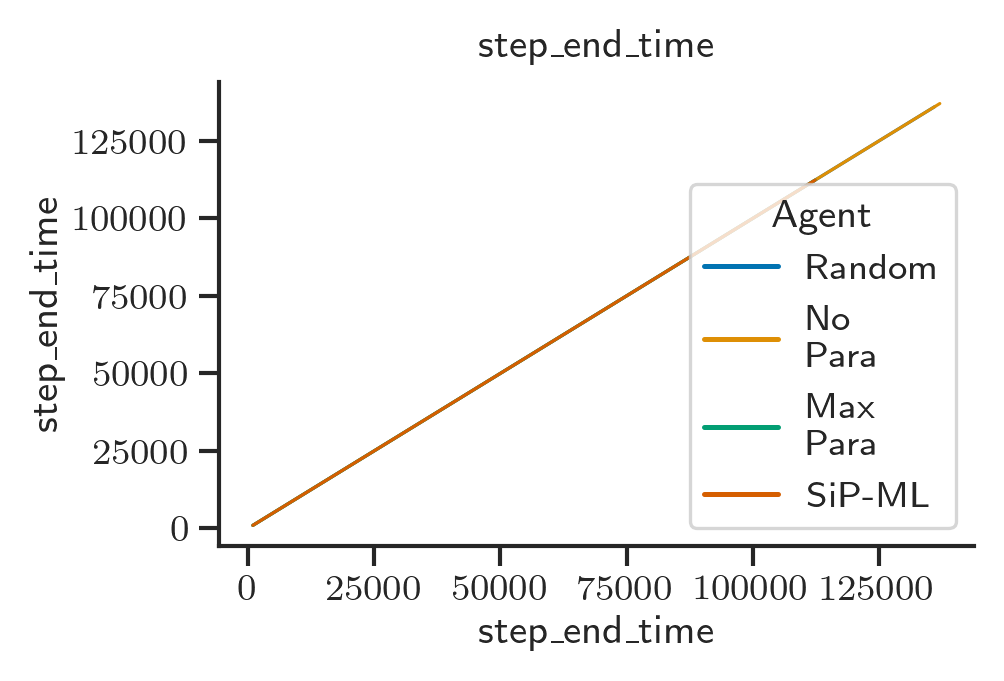

Plotting metric mean_comm_throughput -> min=0.0 | max=45654425.41919495 | mean=21201644.286050584


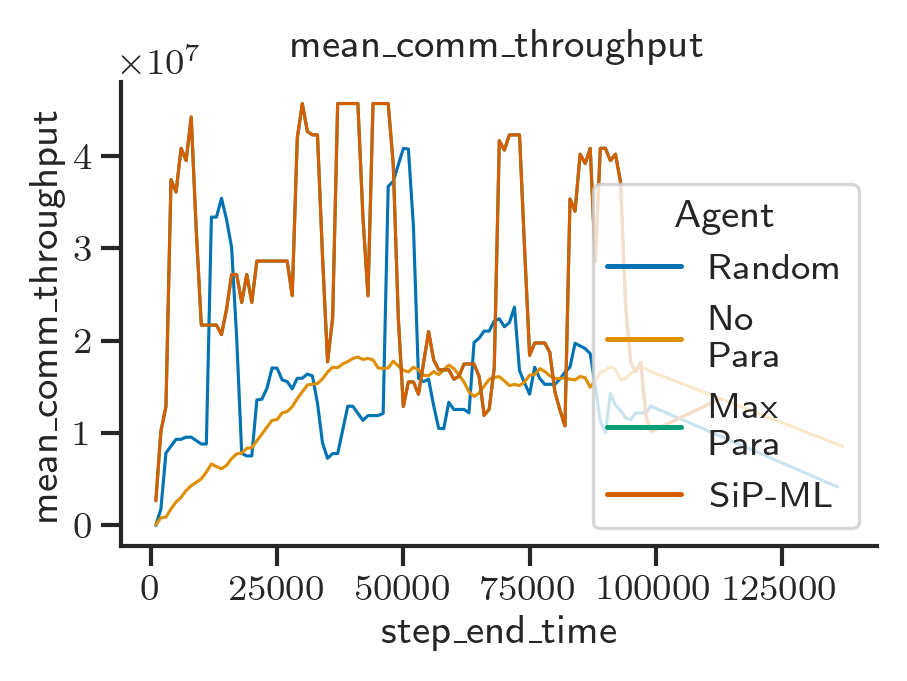

Plotting metric mean_cluster_worker_utilisation_frac -> min=0.03124999999999999 | max=0.9999999999999998 | mean=0.5540095965563115


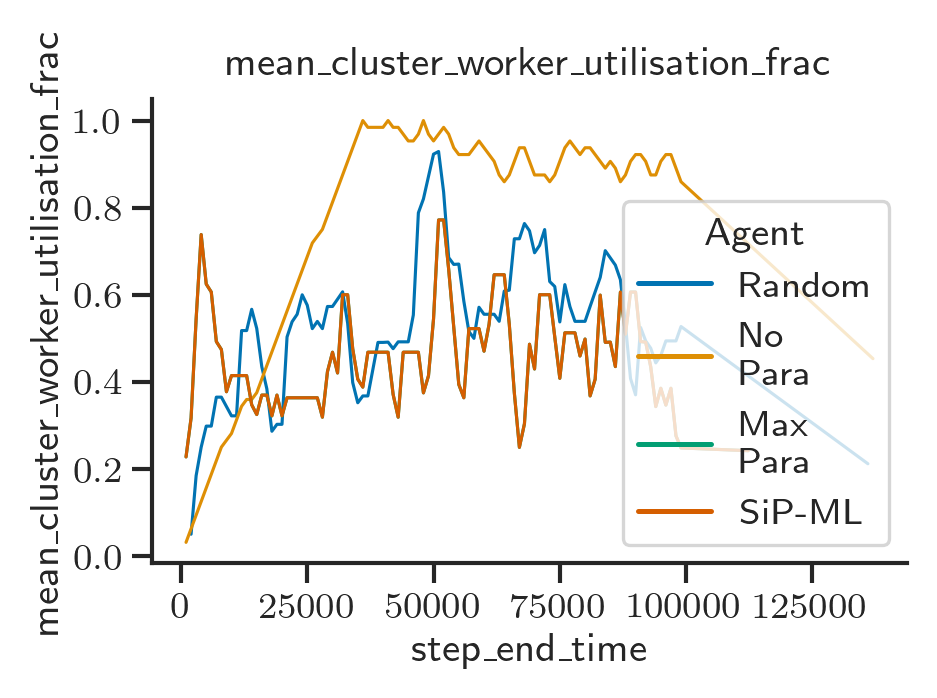

Plotting metric num_jobs_completed -> min=0 | max=28 | mean=0.6275


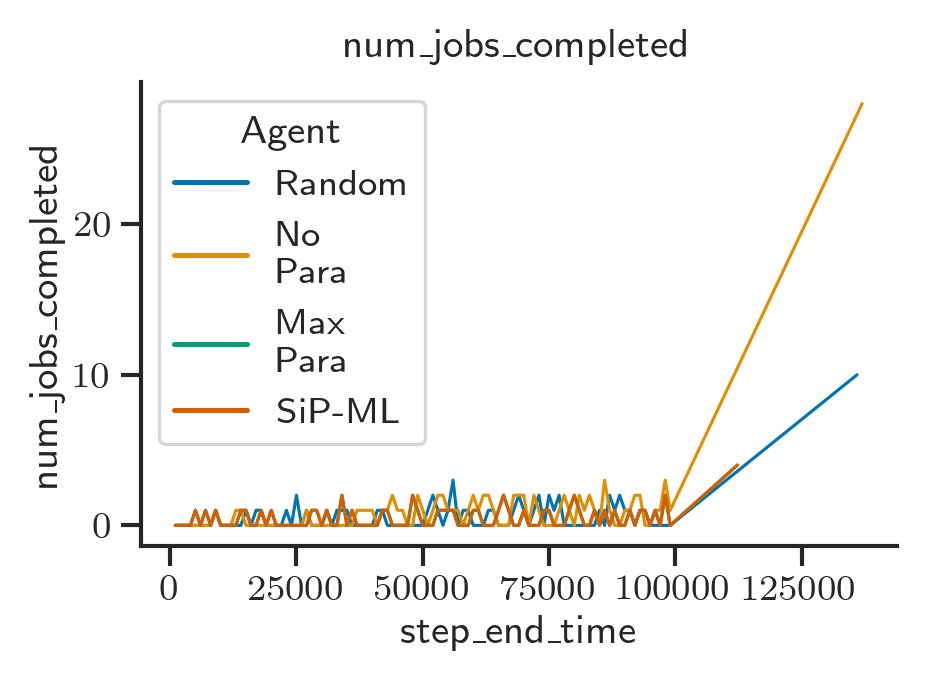

Plotting metric mean_compute_overhead_frac -> min=0.0 | max=1.0 | mean=0.9975


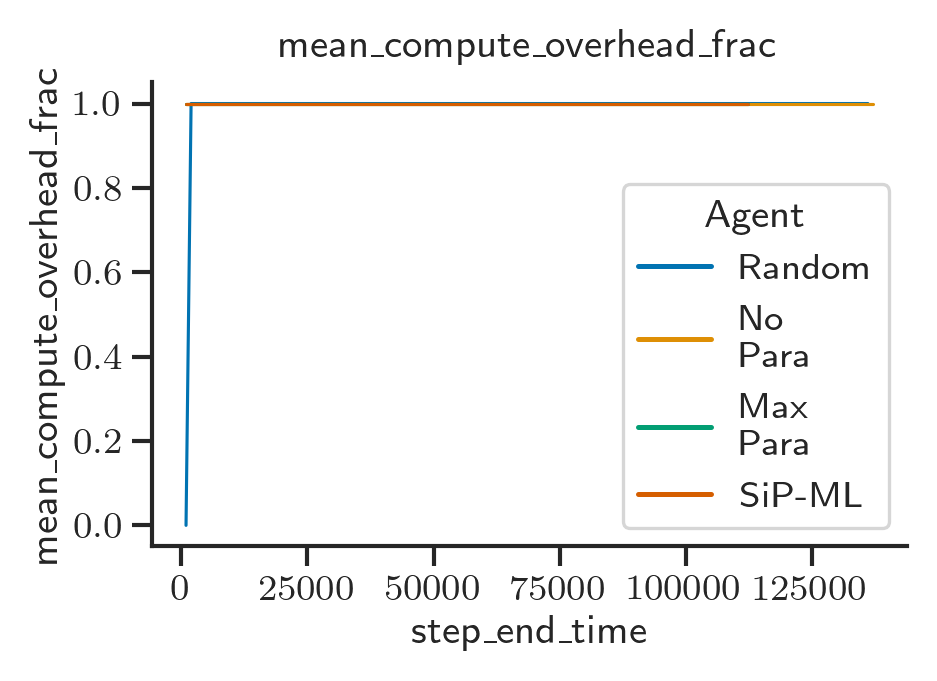

Plotting metric mean_num_mounted_channels -> min=0.0 | max=224.0 | mean=101.83391666666667


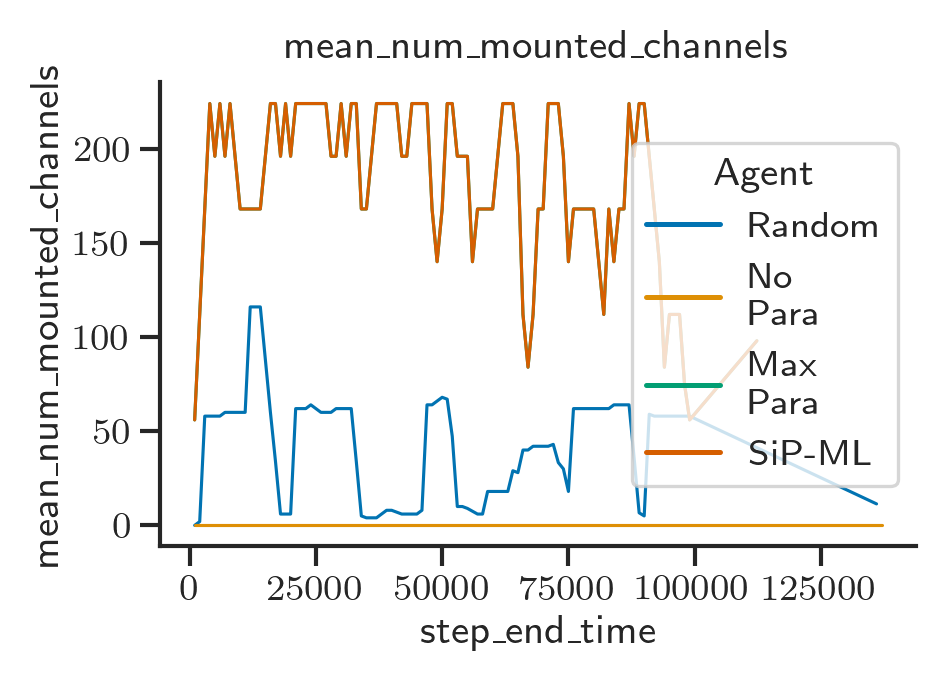

Plotting metric reward -> min=-1.0 | max=-0.013736879611242578 | mean=-0.4172593673984356


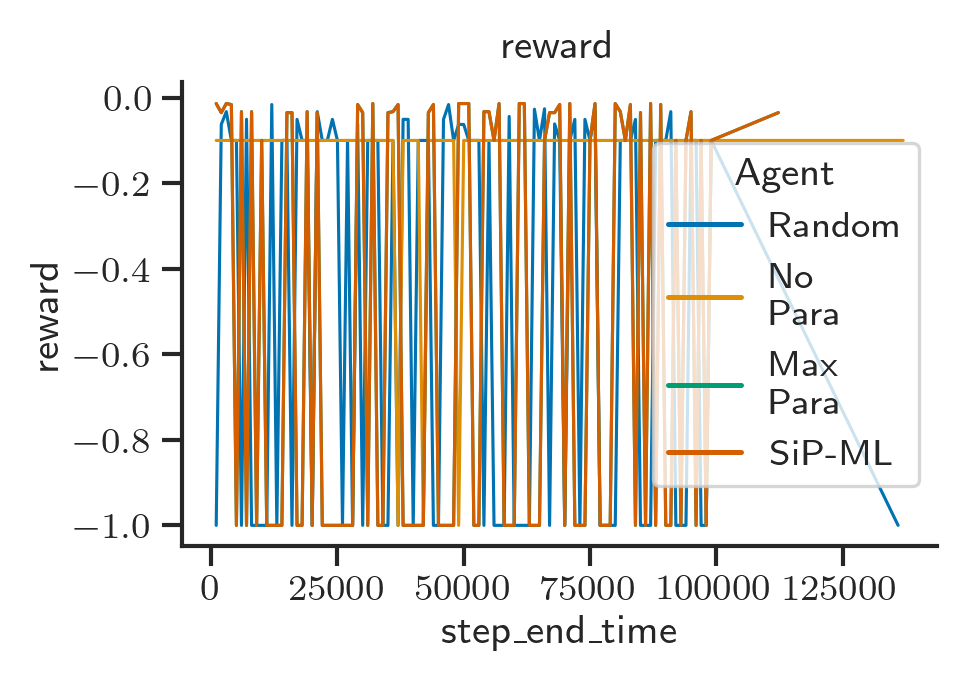

Plotting metric mean_num_jobs_running -> min=0.0 | max=32.0 | mean=10.56125


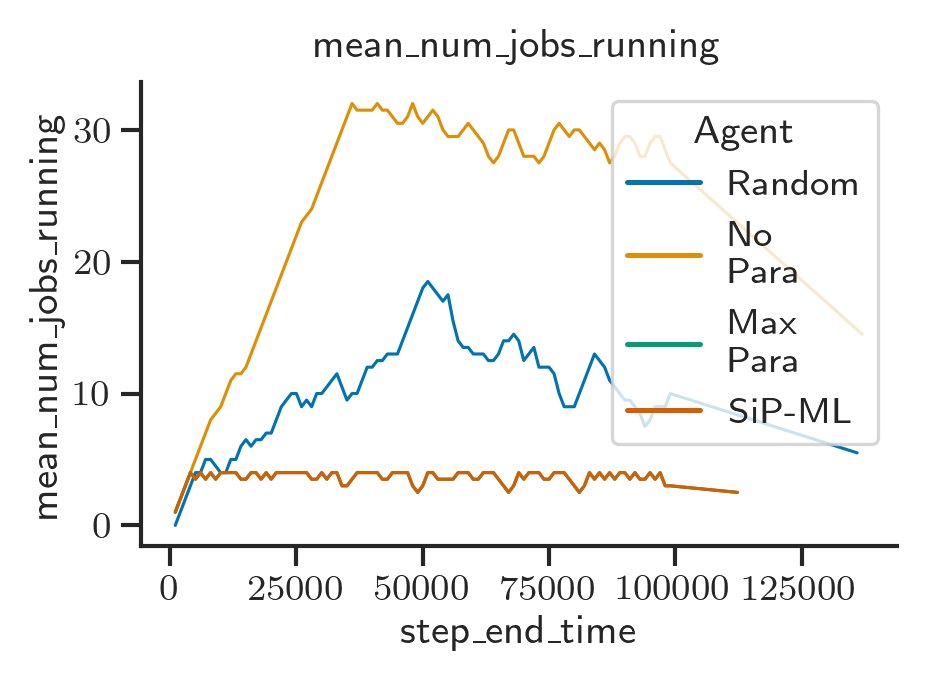

Plotting metric num_jobs_blocked -> min=0 | max=1 | mean=0.3725


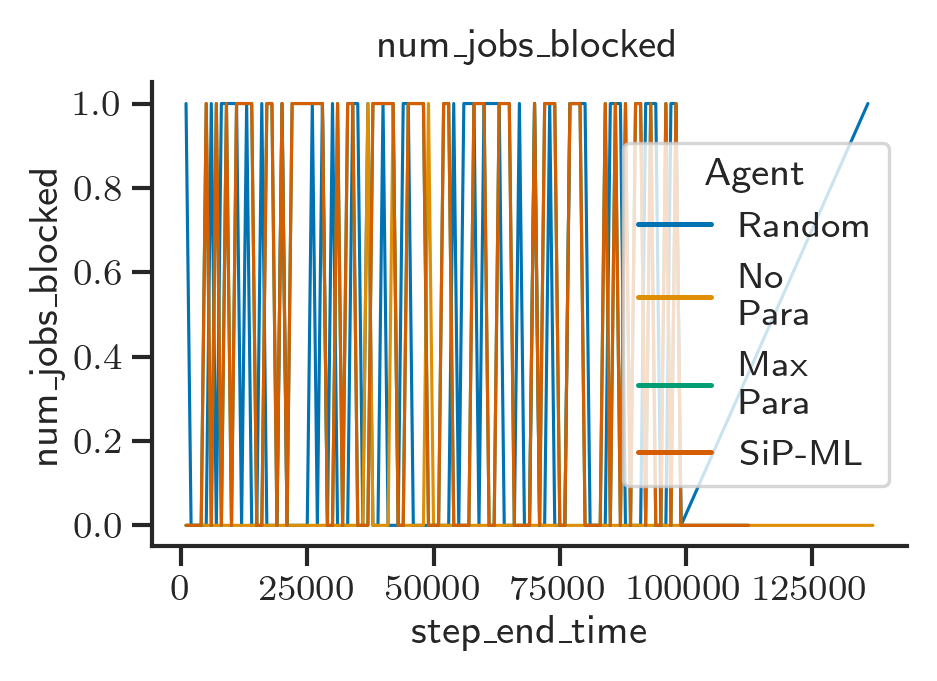

Plotting metric step_start_time -> min=0.0 | max=99000.0 | mean=49500.0


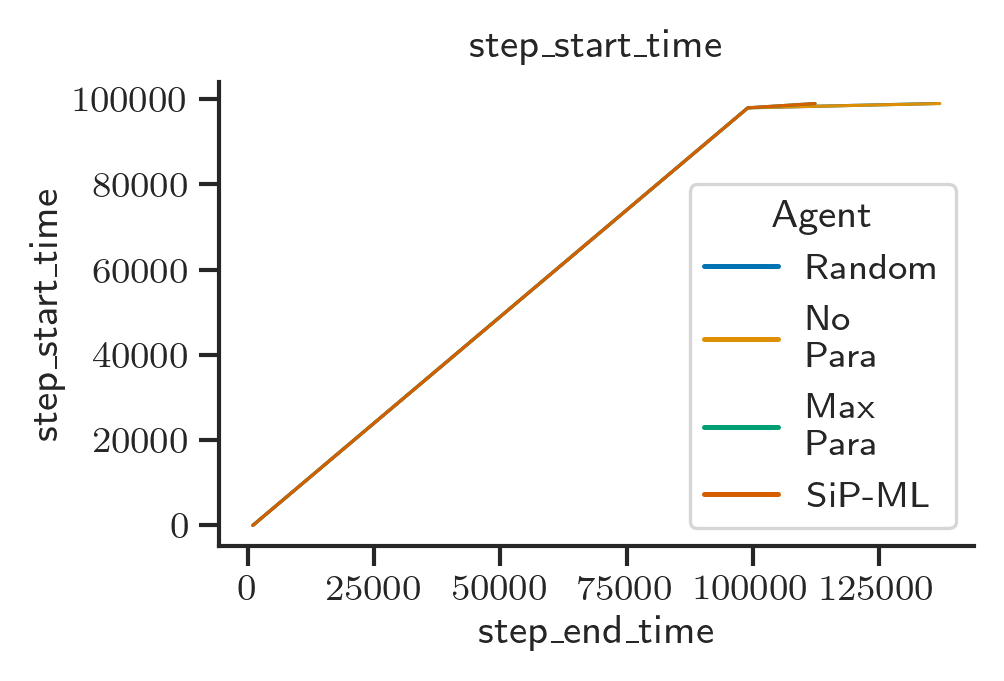

Plotting metric step_counter -> min=0 | max=195 | mean=70.585


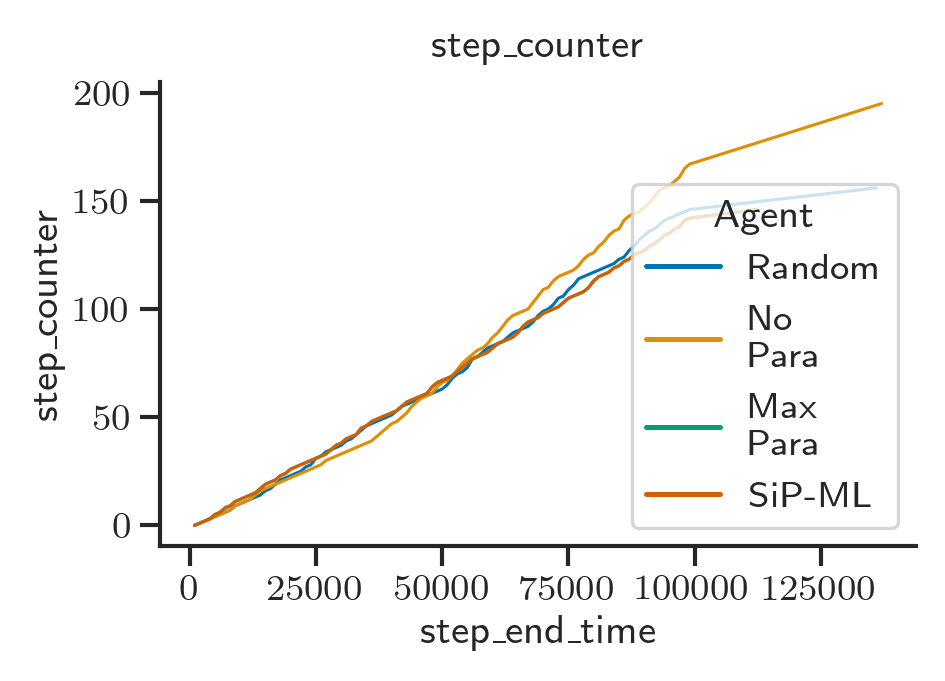

Plotting metric job_queue_length -> min=0 | max=1 | mean=0.99


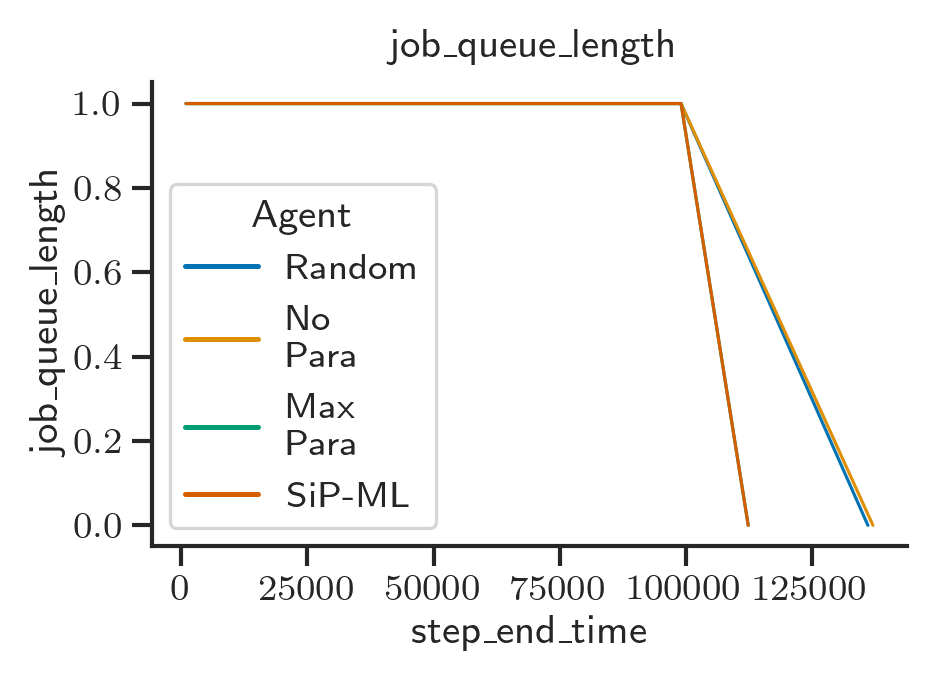

Plotting metric action -> min=0 | max=8 | mean=3.625


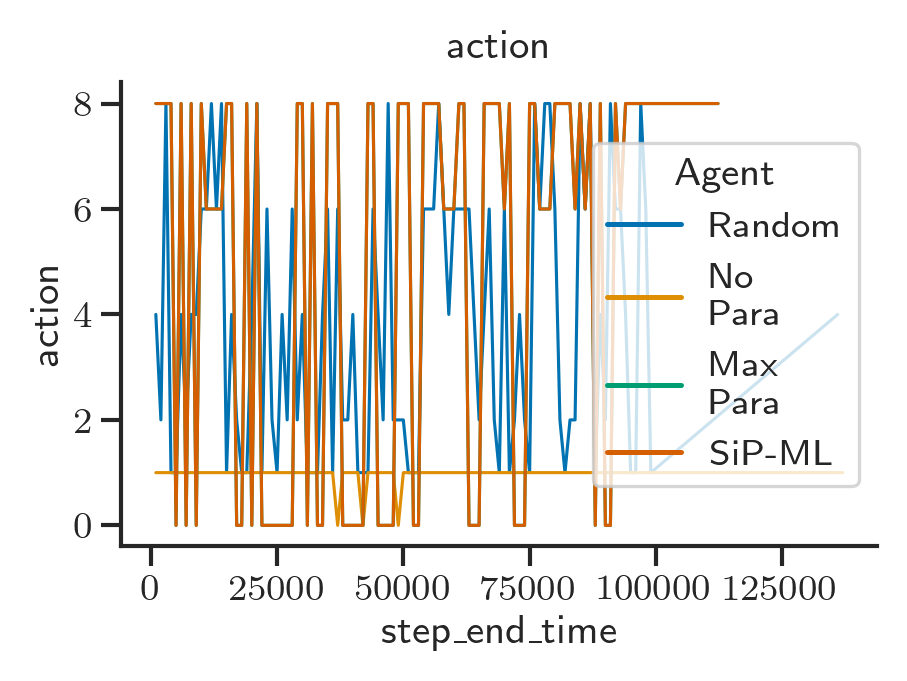

In [128]:
print(f'\n\nEPISODE METRICS')
for metric in episode_metrics:
    barplot(df=episode_stats_df, metric=metric, display_values=display_values)
if len(episode_completion_stats_df) > 0:
    for metric in episode_completion_metrics:
        barplot(df=episode_completion_stats_df, metric=metric)
if len(episode_blocked_stats_df) > 0:
    for metric in episode_blocked_metrics:
        barplot(df=episode_blocked_stats_df, metric=metric)
    
print(f'\n\nSTEP METRICS')
for metric in step_metrics:
    lineplot(df=step_stats_df, metric=metric)